In [1]:
# werkzeug
# shapely=1.7.1
# geopandas
# pandas
# contextily
# matplotlib
# docxtpl
# docx

In [1]:
import sys
sys.path.append('../_amigocloud')

In [2]:
from werkzeug.wrappers import Request, Response
from jinja2 import Template

from datetime import datetime, timedelta

import collections
from amigocloud import AmigoCloud

from datetime import datetime

from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

import qrcode

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)

In [3]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [4]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [5]:
def generar_reporte(codigo_canhero):
    # EXTRAER DATOS DE CREDITO
    query_credito = {'query': 'select * from dataset_307560 where cast(SPLIT_PART(canhero, \'/\', 1) as integer) = {cod_ca}'.format(cod_ca=codigo_canhero)}
    credito_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_credito)
    credito_data = credito_select['data'][0]
    credito_data['fecha_informe'] = (datetime.strptime(credito_data['fecha_1ra_insp'].split(' ')[0], '%Y-%m-%d') + timedelta(days=1)).strftime('%d/%m/%Y')
    credito_data['fecha_1ra_insp'] = datetime.strptime(credito_data['fecha_1ra_insp'].split(' ')[0], '%Y-%m-%d').strftime('%d/%m/%Y')
    credito = collections.namedtuple("credito", credito_data.keys())(*credito_data.values())

    # EXTRAER DATOS DE PROPIEDADES
    query_propiedades = {'query': 'select * from dataset_307562 where insp_ref_prop = \'{insp_ref_prop}\''.format(insp_ref_prop=credito.amigo_id)}
    propiedades_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_propiedades)
    propiedades_data = propiedades_select['data']

    # EXTRAER DATOS DE LOTES
    propiedades = []
    for prop in propiedades_data:
        prop['lotes'] = []
        query_lotes = {'query': 'select * from dataset_307563 where prop_ref_lote=\'{prop_ref_lote}\''.format(prop_ref_lote=prop['amigo_id'])}
        lotes_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_lotes)
        for lote_select in lotes_select['data']:
            lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
            prop['lotes'].append(lote)
        propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))

    # EXTRAER FOTOS
    fotos = []
    for propiedad in propiedades:
        for lote in propiedad.lotes:
            print(lote.lote, lote.amigo_id)
            query_fotos = {'query': 'select source_amigo_id, s3_filename from gallery_46845 where source_amigo_id=\'{source_amigo_id}\''.format(source_amigo_id=lote.amigo_id)}
            fotos_filename = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_fotos)
            if fotos_filename['data'] != []:
                dic = {'lote': lote.lote, 'file_name': fotos_filename['data'][0]['s3_filename']}
                fotos.append(dic)

    # GENERERAR PLANOS
    i = 0
    lista_planos = []
    for propiedad in propiedades:
        i = i + 1
        lista_planos.append(generar_plano(propiedad, i))
    
    
    # GENERAR QR
    texto = '''
--UTEA--
--1RA INSPECCION CREDITO SIEMBRA--

Codigo de Inspeccion: {cite}
Fecha de Inspeccion: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Total Solicitado: {soli}
Total Area Insp.: {total_area} ha
Estado de Insp.: {estado}
Tecnico Responsable: {tecnico}'''\
    .format(
        cite=str(credito.cite_1ra_insp) + '-' + credito.fecha_1ra_insp.split('/')[2], 
        fecha=credito.fecha_1ra_insp, 
        canero=credito.canhero.split(' / ')[1],
        cod_ca=credito.canhero.split(' / ')[0],
        soli=credito.solicitado,
        total_area=credito.total_1ra_insp,
        estado=credito.estado_1ra_insp,
        tecnico=credito.respon_1ra_insp)
    # Generar el código QR
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(texto)
    qr.make(fit=True)
    
    qr_img = qr.make_image(fill_color="black", back_color="white")
    
    cod_ca = credito.canhero.split(' / ')[0]
    nom_ca = credito.canhero.split(' / ')[1]
    filename_qr = "qr_" + cod_ca + '_CRS_' + credito.fecha_informe.replace('/', '-') + '_' + nom_ca
    ruta_qr = ruta + '/planos/' + filename_qr + '.png'
    # Guardar el código QR en un archivo
    qr_img.save(ruta_qr)

    
    
    
    

        
    # GENERAR REPORTE
    doc = DocxTemplate(ruta + "/templates/tpl_inf_credito_1ra.docx")
    #generar lista de InlineImage de planos 
    lista_InlineImage = []
    for plano in lista_planos:
        lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))
    #descargar fotos y generar lista InlineImage
    lista_fotos_inline = []
    for foto in fotos:
        #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
        response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
        file = open(ruta + '/fotos/' + foto['file_name'], "wb")
        file.write(response.content)
        file.close()
        lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor=ruta+'/fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})
    firma_respon = None
    if credito.respon_1ra_insp == 'Rogelio Acuña Rodríguez':
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta+'/templates/firma_rogelio.png', width=Mm(60))
    else:
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta+'/templates/firma_jaldin.png', width=Mm(60))
    # se crea obj inline par imagen QR
    qr_file = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
    
    context = {'credito':credito, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon, 'qr':qr_file}
    doc.render(context)
    cod_ca = credito.canhero.split(' / ')[0]
    nom_ca = credito.canhero.split(' / ')[1]
    print(credito)
    file_name = "_" + cod_ca + '_CRS_' + credito.fecha_informe.replace('/', '-') + '_' + nom_ca
    doc.save(ruta + '/informes/' + file_name + '.docx')

In [6]:
def generar_plano(propiedad, i):
    lotes_lista = []
    for lote in propiedad.lotes:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    path = ruta+'/planos/' + str(propiedad.amigo_id) + '.jpeg'
    fig.savefig(path, dpi = 300, bbox_inches='tight')
    plt.clf()
    return path

In [7]:
semana = 'S51'
query = {'query': 'select split_part(canhero, \' / \', 1) cod, split_part(canhero, \' / \', 2) nom from dataset_307560 where semana_1ra = \'{sem}\''.format(sem=semana)}
project = 'https://app.amigocloud.com/api/v1/projects/32672/sql'
select = amigocloud.get(project, query)
data = select['data']

In [8]:
data

[{'cod': '30907', 'nom': 'ALVAREZ FUENTES JUAN CARLOS'},
 {'cod': '5421', 'nom': 'HUBBAUER HOYOS ENRIQUE'},
 {'cod': '5006', 'nom': 'GARCIA MARISCAL MILTON FELIX'},
 {'cod': '7385', 'nom': 'LINARES SALVATIERRA MARY LUZ'},
 {'cod': '41827', 'nom': 'SALAZAR PERALTA GABRIELA'}]

In [9]:
#lista = [1068, 18062, 10739, 41955, 2392, 15162, 2517, 8706, 15085, 430, 874, 5498, 2505, 2274]
lista = [int(i['cod']) for i in data]

In [10]:
print(len(lista), 'informes')

5 informes


In [11]:
lista

[30907, 5421, 5006, 7385, 41827]

L2.3 23387abba32244e39092c8ab18bb5981
L30.3 756458d9fc9144a3a1c80cd2c1392ed6
L25 0dc90a62cc1743b7bd7c88536a942981
L21 ca30732341934db69446b1e002761c91
L26 9f18ea996882462caeb22e176e428582
L19 4b515baef4d14a3989e345c655208220
L23 a315ff84c3be4c57b6272ceb6f8fccf7
L4 3b9081fa180945158125a122649f8ef6
L3 51387d78835d46b09f23c0f38a157bcf
L2 97b2ce2a251246408f8216f621d99f6b
L1 86f8c2012bcc4675b9f0cdb06a1a71be
credito(fecha_registro='2023-11-16 00:59:31.305131+00:00', amigo_id='335ef4ad8d44428995cfb441fcb56fd7', semana_1ra='S51', semana_2da=None, institucion=50, canhero='30907 / ALVAREZ FUENTES JUAN CARLOS', solicitado=50.0, total_1ra_insp=48.56, estado_1ra_insp='APROBADO', fecha_1ra_insp='28/11/2023', cite_1ra_insp=561, respon_1ra_insp='Juan Pablo Jaldin Duran', obs_1ra=None, link_doc_1ra='https://drive.google.com/file/d/14YAaO_FU3CcItHwNL4AUIAYqrk_BzoDw/view?usp=drivesdk', total_2da_insp=None, estado_2da_insp=None, fecha_2da_insp=None, cite_2da_insp=None, respon_2da_insp=None, obs_2da=None, 

KeyboardInterrupt: 

<Figure size 2000x2000 with 0 Axes>

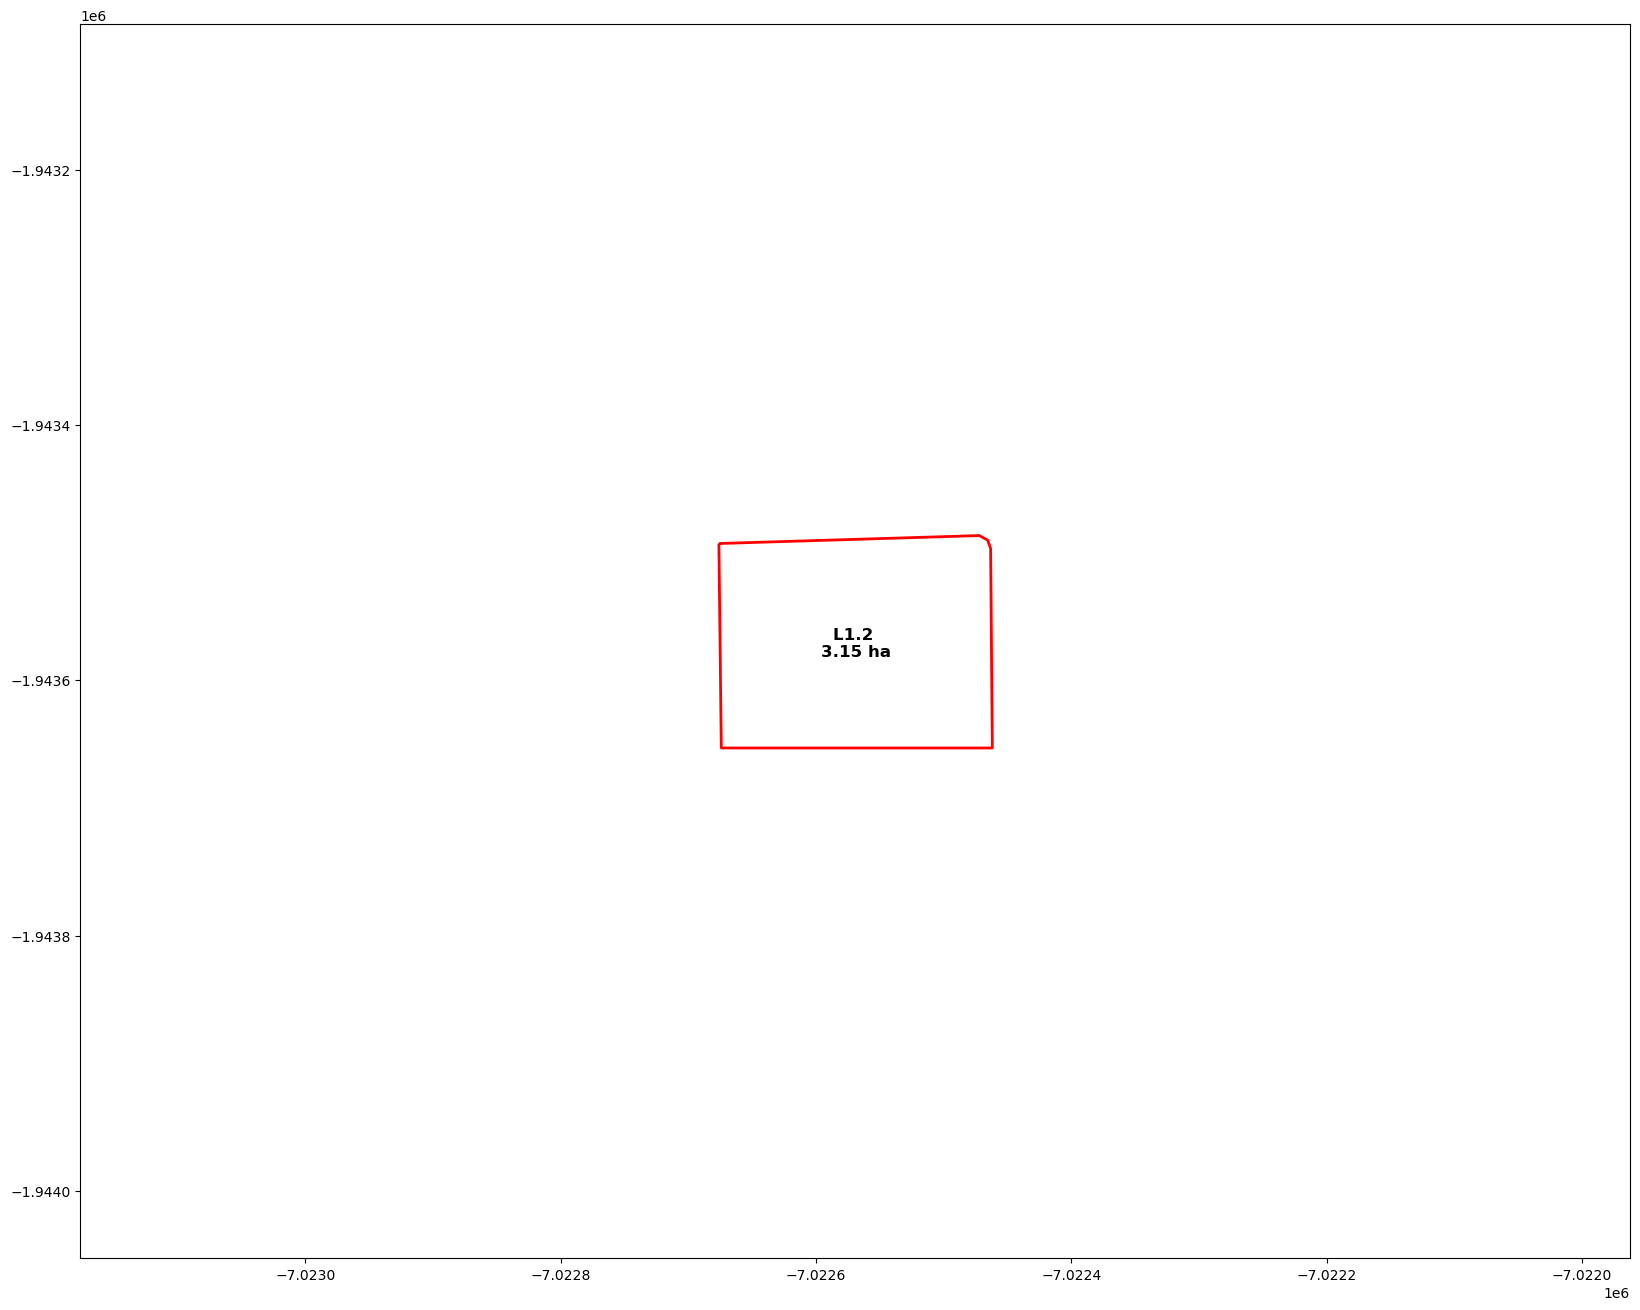

In [12]:
for i in lista:
    generar_reporte(i)
    print('======================', i)